In [1]:
#default_exp utils

In [9]:
#export utils
import numpy as np
from pyproj import CRS, Transformer
from PIL import Image
from osmread import parse_file, Way, Node


crs_4326  = CRS.from_epsg(4326) # epsg 4326 is wgs84
crs_25832  = CRS.from_epsg(25832) # epsg 25832 is etrs89
transformer = Transformer.from_crs(crs_4326, crs_25832)


In [10]:
#export utils
def giveHeading(x1,y1,x2,y2):
        assert not (x1==x2 and y1==y2), "Can't give heading without a direction"
        x = [x1,x2]
        y = [y1,y2]
        x_arr=np.array(x)-x[0]
        y_arr=np.array(y)-y[0]
        #rotate to initial approximately 0
        #umrechnen in polarkoordinaten des ersten abstandes
        if x_arr[1] > 0:
                    phi = np.arctan(y_arr[1]/x_arr[1])
        elif x_arr[1] == 0:
                    if y_arr[1] > 0:
                            phi = np.pi/2
                    else:
                            phi = -np.pi/2
        else:
                    if y_arr[1] >= 0:
                            phi = np.arctan(y_arr[1]/x_arr[1])+np.pi
                    else:
                            phi = np.arctan(y_arr[1]/x_arr[1])-np.pi
        return getPositiveHeading(phi)


In [11]:
for i in np.arange(-3.2,3.3,0.1):
    x1 = 1.0
    y1 = 1.0
    x2 = 1.+np.cos(i)*2.0
    y2 = 1.+np.sin(i)*2.0
    print("realhdg = {0}, calc = {1}".format(i,giveHeading(x1,y1,x2,y2)))
    

realhdg = -3.2, calc = 3.083185307179586
realhdg = -3.1, calc = -3.1
realhdg = -3.0, calc = -3.0
realhdg = -2.9, calc = -2.9
realhdg = -2.8, calc = -2.8
realhdg = -2.6999999999999997, calc = -2.6999999999999997
realhdg = -2.5999999999999996, calc = -2.5999999999999996
realhdg = -2.4999999999999996, calc = -2.4999999999999996
realhdg = -2.3999999999999995, calc = -2.3999999999999995
realhdg = -2.2999999999999994, calc = -2.2999999999999994
realhdg = -2.1999999999999993, calc = -2.1999999999999993
realhdg = -2.099999999999999, calc = -2.099999999999999
realhdg = -1.9999999999999991, calc = -1.999999999999999
realhdg = -1.899999999999999, calc = -1.8999999999999988
realhdg = -1.799999999999999, calc = -1.799999999999999
realhdg = -1.6999999999999988, calc = -1.6999999999999986
realhdg = -1.5999999999999988, calc = -1.5999999999999985
realhdg = -1.4999999999999987, calc = -1.4999999999999987
realhdg = -1.3999999999999986, calc = -1.3999999999999986
realhdg = -1.2999999999999985, calc = -1.

In [12]:
#export utils
def checkDistance(x,y,x2,y2):
    x_m = (x+x2)/2.0
    y_m = (y+y2)/2.0
    r = ((x_m-x)**2+(y_m-y)**2)**0.5
    [_,_],phi,_,_ = rotateToXAxis([x_m,x2],[y_m,y2])
    return x_m, y_m, r, phi


In [13]:
#export utils
def drehen(x,y,phi, drehpunkt = [0,0], offset = False):
        x = np.array(x)-drehpunkt[0]
        y = np.array(y)-drehpunkt[1]
        dmat =  np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
        x_new = []
        y_new = []
        for i in range(len(x)):
            points = np.matmul(dmat,np.hstack((x[i],y[i])))
            x_new.append(points[0])
            y_new.append(points[1])
        x_new = np.array(x_new)
        y_new = np.array(y_new)
        if offset:
            x_new = x_new+drehpunkt[0]
            y_new = y_new+drehpunkt[1]
        return x_new, y_new

In [14]:
#export utils
def rotateToXAxis(x,y):
        x_arr=np.array(x)-x[0]
        y_arr=np.array(y)-y[0]
        #rotate to initial approximately 0
        #umrechnen in polarkoordinaten des ersten abstandes
        if x_arr[1] > 0:
                    phi = np.arctan(y_arr[1]/x_arr[1])
        elif x_arr[1] == 0:
                    if y_arr[1] > 0:
                            phi = np.pi/2
                    else:
                            phi = -np.pi/2
        else:
                    if y_arr[1] >= 0:
                            phi = np.arctan(y_arr[1]/x_arr[1])+np.pi
                    else:
                            phi = np.arctan(y_arr[1]/x_arr[1])-np.pi
        phi = -phi
        x_arr,y_arr = drehen(x_arr,y_arr,phi)
        return [x[0],y[0]],phi,x_arr,y_arr

In [15]:
#export utils

def getXYPositionFromLineLength(xstart, ystart, heading, length):
    xend = xstart + np.cos(heading) * length
    yend = ystart + np.sin(heading) * length
    return xend, yend


In [16]:
#export utils
global referenceLat
global referenceLon
referenceLat = None
referenceLon = None


global topoParameter
global topomap
def convertTopoMap(topomappath, osmpath):
        global topomap
        global topoParameter
        try:
                topomap =  np.array(Image.open(topomappath))[:,:,0] #y,x,rgba
        except:
                topomap =  np.array(Image.open(topomappath))[:,:] #y,x,rgba
        topomap=np.rot90(topomap)
        topomap=np.rot90(topomap)
        topoParameter = giveMaxMinLongLat(osmpath)
        return topoParameter

global maximumheight, minimumheight
maximumheight = 0.0
minimumheight = 0.0
def setHeights(minimum, maximum):
        global maximumheight, minimumheight
        minimumheight = minimum
        maximumheight  = maximum


In [17]:
#export utils
def giveHeight(x,y,minRemoved = False):
                global topoParameter
                global topomap
                global maximumheight, minimumheight
                if not minRemoved:
                        x_lookup= int(topomap.shape[1]*(x-topoParameter[0])/(topoParameter[1]-topoParameter[0]))
                        y_lookup = int(topomap.shape[0]*(1.0-(y-topoParameter[2])/(topoParameter[3]-topoParameter[2])))
                else:
                        x_lookup= int(topomap.shape[1]*x/(topoParameter[1]-topoParameter[0]))
                        y_lookup = int(topomap.shape[0]*(1.0-(y/(topoParameter[3]-topoParameter[2]))))
                x_lookup = min(max(topomap.shape[1]-x_lookup-1,0),topomap.shape[1]-1)
                y_lookup = min(max(topomap.shape[0]-1-y_lookup,0),topomap.shape[0]-1)
                height = topomap[y_lookup,x_lookup]-np.min(topomap)
                height = height/np.max(topomap) 
                height = height * (maximumheight-minimumheight) + minimumheight
                return height

In [18]:
#export utils
def giveMaxMinLongLat(osmpath, trustOSMHeaderMinMax = False):
        minlat = 999999.0
        maxlat = 0.0
        minlon = 999999.0
        maxlon = 0.0
        for entity in parse_file(osmpath):
                if isinstance(entity, Node):
                        if minlat > entity.lat:  
                                minlat = entity.lat
                        if maxlat < entity.lat:
                                maxlat = entity.lat
                        if minlon > entity.lon:
                                minlon = entity.lon
                        if maxlon < entity.lon:
                                maxlon = entity.lon

        if trustOSMHeaderMinMax:
                with open(osmpath, "r") as f:
                        for line in f:
                                if "minlat='" in line:
                                        minlat = float(line.split("minlat='")[1].split("'")[0])
                                if "maxlat='" in line:
                                        maxlat = float(line.split("maxlat='")[1].split("'")[0])
                                if "maxlon='" in line:
                                        maxlon = float(line.split("maxlon='")[1].split("'")[0])
                                if "minlon='" in line:
                                        minlon = float(line.split("minlon='")[1].split("'")[0])
                                if 'minlat="' in line:
                                        minlat = float(line.split('minlat="')[1].split('"')[0])
                                if 'maxlat="' in line:
                                        maxlat = float(line.split('maxlat="')[1].split('"')[0])
                                if 'maxlon="' in line:
                                        maxlon = float(line.split('maxlon="')[1].split('"')[0])
                                if 'minlon="' in line:
                                        minlon = float(line.split('minlon="')[1].split('"')[0])
        print("minlon = {},minlat= {},maxlon = {},maxlat = {}".format(minlon,minlat,maxlon,maxlat))
        xmin,ymin = convertLongitudeLatitude(minlon,minlat)
        xmax,ymax = convertLongitudeLatitude(maxlon,maxlat)
        return xmin, xmax, ymin, ymax


In [1]:
#export utils
def convertLongitudeLatitude(longitude,latitude):
        #return longitude, latitude
        global referenceLat
        global referenceLon

        x,y = next(transformer.itransform([(latitude,longitude)]))

        '''if referenceLat is None:
            referenceLat = latitude
            referenceLon = longitude'''
        #x = latitude
        #y = longitude
        return x,y
    


In [20]:
#export utils
def distance(x1,y1,x2,y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [21]:
#export utils
def schnittpunkt(x1,y1,hdg1,x2,y2,hdg2):
    #x1 + np.cos(hdg1) * r1 = x2 + np.cos(hdg2) * r2 = x_s
    #y1 + np.sin(hdg1) * r1 = y2 + np.sin(hdg2) * r2 = y_s
    
    #r1 =   (x2-x2 + np.cos(hdg2) * r2) /(np.cos(hdg1))
    #alt r1 = (y2-y1 + np.sin(hdg2) * r2) /(np.sin(hdg1))
    
    #---> r2= (x1-x2 + np.cos(hdg1) * r1)/np.cos(hdg2) 
    #---> alt: r2= (y1 -y2+ np.sin(hdg1) * r1 )/np.sin(hdg2)
    #r2 ersetzen
    #y1 + np.sin(hdg1) * r1 = y2 + np.sin(hdg2) * (x1-x2 + np.cos(hdg1) * r1)/np.cos(hdg2)
    #alt: x1 + np.cos(hdg1) * r1 = x2 + np.cos(hdg2) * (y1 -y2+ np.sin(hdg1) * r1 )/np.sin(hdg2)
    #r1 ersetzen
    #y1 + np.sin(hdg1) * (x2-x2 + np.cos(hdg2) * r2) /(np.cos(hdg1)) = y2 + np.sin(hdg2) * r2
    if abs(np.sin(hdg1) * np.cos(hdg2) - np.sin(hdg2) *np.cos(hdg1)) < 0.02:
        r2 = ( y1*np.cos(hdg1) + np.sin(hdg1) * (x2-x2)-y2*np.cos(hdg1)) /((np.sin(hdg2)*np.cos(hdg1) - np.sin(hdg1) *np.cos(hdg2) ))
        if abs(abs(hdg1) -np.pi/2.0) < 0.2:
            r1 = (y2-y1 + np.sin(hdg2) * r2) /(np.sin(hdg1))
        else:
            r1 =   (x2-x2 + np.cos(hdg2) * r2) /(np.cos(hdg1))
    else:
        r1 = (-y1*np.cos(hdg2)+ y2*np.cos(hdg2) + np.sin(hdg2) *x1-np.sin(hdg2) *x2 )/(np.sin(hdg1) * np.cos(hdg2) - np.sin(hdg2) *np.cos(hdg1))
        if abs(abs(hdg2) -np.pi/2.0) < 0.2:
            r2 = (y1 -y2+ np.sin(hdg1) * r1 )/np.sin(hdg2)
        else:
            r2 = (x1-x2 + np.cos(hdg1) * r1)/np.cos(hdg2)
    x_s = x1 + np.cos(hdg1) * r1
    y_s = y1 + np.sin(hdg1) * r1
    return x_s,y_s,r1,r2

In [32]:
#export utils
def createVirtualLastPointForJunctionRoads(jx,jy,jrxs,jrys,radius = 3.0):
    lastPoints = []
    for i in range(len(jrxs)):
        x = jrxs[i]
        y = jrys[i]
        hdg1 = giveHeading(jx,jy,x,y)
        #get the 4 points to either side of the road
        hdg1_90 = hdg1-np.pi/2.0
        x1t1 = x + radius*np.cos(hdg1_90)
        y1t1 = y + radius*np.sin(hdg1_90)
        x1t2 = x - radius*np.cos(hdg1_90)
        y1t2 = y - radius*np.sin(hdg1_90)
        relevantr = [min(distance(jx,jy,x,y)*0.9,radius)] #0.9 da es die vorletzten Punkte des Weges sind->
        #                                                  ansonsten sind die vorletzten und letzen punkte gleich
        for j in range(len(jrxs)):
            if i == j:
                continue
            x2 = jrxs[j]
            y2 = jrys[j]
            hdg2 = giveHeading(jx,jy,x2,y2)
            #get the 4 points besides this line
            hdg2_90 = hdg2-np.pi/2.0
            x2t1 = x2 + radius*np.cos(hdg2_90)
            y2t1 = y2 + radius*np.sin(hdg2_90)
            x2t2 = x2 - radius*np.cos(hdg2_90)
            y2t2 = y2 - radius*np.sin(hdg2_90)
            # get the 4 intersectionPoints
            ix1,iy1,_,_ = schnittpunkt(x1t1,y1t1,hdg1,x2t1,y2t1,hdg2)
            ix1,iy1,_,_ = schnittpunkt(ix1,iy1,hdg1_90,x,y,hdg1)
            ix2,iy2,_,_ = schnittpunkt(x1t2,y1t2,hdg1,x2t1,y2t1,hdg2)
            ix2,iy2,_,_ = schnittpunkt(ix2,iy2,hdg1_90,x,y,hdg1)
            ix3,iy3,_,_ = schnittpunkt(x1t1,y1t1,hdg1,x2t2,y2t2,hdg2)
            ix3,iy3,_,_ = schnittpunkt(ix3,iy3,hdg1_90,x,y,hdg1)
            ix4,iy4,_,_ = schnittpunkt(x1t2,y1t2,hdg1,x2t2,y2t2,hdg2)
            ix4,iy4,_,_ = schnittpunkt(ix4,iy4,hdg1_90,x,y,hdg1)
            ix = [ix1,ix2,ix3,ix4]
            iy = [iy1,iy2,iy3,iy4]
            #get the radius from relevant intersections
            for k in range(4):
                if min(x,jx)<ix[k]<max(x,jx) and min(y,jy)<iy[k]<max(y,jy): #point is on Line x,y to jx,jy! Relevant
                    relevantr.append(distance(ix[k],iy[k],jx,jy))
        lasty,lastx = getXYPositionFromLineLength(jx, jy, hdg1, max(relevantr))
        lastPoints.append([lasty,lastx])
    return lastPoints

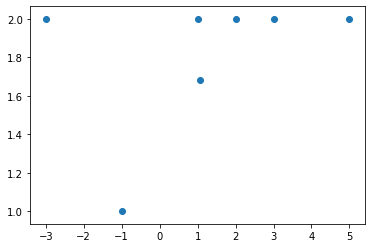

[[1.0, 2.0], [1.0513167019494862, 1.683772233983162], [3.0, 2.0]]


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

startpointsX = [-3,-1.,5.]
startpointsY = [2.,1.,2.]
junctionX = 2.
junctionY = 2.
vPoints = createVirtualLastPointForJunctionRoads(junctionX,junctionY,startpointsX,startpointsY,radius = 1.0)
endpointsX = np.array(vPoints).swapaxes(1,0)[0].tolist()
endpointsY = np.array(vPoints).swapaxes(1,0)[1].tolist()

plt.scatter(startpointsX+[junctionX]+endpointsX,startpointsY+[junctionY]+endpointsY)
plt.show()

print(createVirtualLastPointForJunctionRoads(junctionX,junctionY,startpointsX,startpointsY,radius = 1.0))


In [53]:
#export utils
def getPositiveHeading(hdg):
    while hdg < 0.0:
         hdg+=2.0*np.pi
    return hdg%(np.pi*2.0)
    
def getDeltaHdg(hdg1,hdg2):
    hdg1 = getPositiveHeading(hdg1)
    hdg2 = getPositiveHeading(hdg2)
    deltaHdg = hdg1-hdg2
    if abs(deltaHdg)//np.pi == 1: 
        deltaHdg = (abs(deltaHdg)%np.pi) * np.sign(deltaHdg)
        deltaHdg = np.pi+deltaHdg if deltaHdg < 0.0 else -np.pi + deltaHdg
    else:
        deltaHdg = (abs(deltaHdg)%np.pi) * np.sign(deltaHdg)
    return deltaHdg
        

In [55]:
for hdg1 in np.arange(-6.1,6.2,0.25):
    print("{0} diff: {2}  {1}".format(hdg1,getDeltaHdg(hdg1,1.0),getPositiveHeading(hdg1)-0.0))

-6.1 diff: 0.1831853071795866  -0.8168146928204134
-5.85 diff: 0.4331853071795866  -0.5668146928204134
-5.6 diff: 0.6831853071795866  -0.3168146928204134
-5.35 diff: 0.9331853071795866  -0.06681469282041341
-5.1 diff: 1.1831853071795866  0.1831853071795866
-4.85 diff: 1.4331853071795866  0.4331853071795866
-4.6 diff: 1.6831853071795866  0.6831853071795866
-4.35 diff: 1.9331853071795866  0.9331853071795866
-4.1 diff: 2.1831853071795866  1.1831853071795866
-3.8499999999999996 diff: 2.4331853071795866  1.4331853071795866
-3.5999999999999996 diff: 2.6831853071795866  1.6831853071795866
-3.3499999999999996 diff: 2.9331853071795866  1.9331853071795866
-3.0999999999999996 diff: 3.1831853071795866  2.1831853071795866
-2.8499999999999996 diff: 3.4331853071795866  2.4331853071795866
-2.5999999999999996 diff: 3.6831853071795866  2.6831853071795866
-2.3499999999999996 diff: 3.9331853071795866  2.9331853071795866
-2.0999999999999996 diff: 4.183185307179587  -3.0999999999999996
-1.8499999999999996 d